# Imports

In [1]:
import glob
import re
from pathlib import Path

import abbreviate
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from PIL import Image
from skimage.io import imread
from skimage.transform import resize

sns.set_style("whitegrid", {'axes.grid': False})

abbr = abbreviate.Abbreviate()

c:\Users\thoma\anaconda3\lib\site-packages\scipy\__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


# Create dataframe

In [2]:
def create_dataframe(path):
    files = np.array(glob.glob(str(path)))
    files = np.array([Path(file) for file in files])
    files_df = pd.DataFrame(files).rename(columns={0: "filename"})
    # get class name from filename
    files_df['class'] = files_df['filename'].apply(lambda x: x.parent.name)
    # get city name from filename
    files_df['city'] = files_df['filename'].apply(
        lambda x: x.parent.parent.name)

    return files_df

In [3]:
# read image files to dataframe
jpg_path = Path("./extracted-data/imagery/") / Path('*/*/*.jpg')

files_df = create_dataframe(jpg_path)
files_df.head()

,filename,class,city
0,"extracted-data\imagery\athina, gr\Agricultural...",Agricultural + Semi-natural areas + Wetlands,"athina, gr"
1,"extracted-data\imagery\athina, gr\Agricultural...",Agricultural + Semi-natural areas + Wetlands,"athina, gr"
2,"extracted-data\imagery\athina, gr\Agricultural...",Agricultural + Semi-natural areas + Wetlands,"athina, gr"
3,"extracted-data\imagery\athina, gr\Agricultural...",Agricultural + Semi-natural areas + Wetlands,"athina, gr"
4,"extracted-data\imagery\athina, gr\Agricultural...",Agricultural + Semi-natural areas + Wetlands,"athina, gr"


## Filter dataframe

Remove classes with low number of samples

In [4]:
minimum_samples = 5
low_sample_classes = list(files_df['class'].value_counts()[
                            files_df['class'].value_counts() < minimum_samples].index)

files_df = files_df[~files_df['class'].isin(low_sample_classes)]

# Plot examples

In [5]:
def split_str(s, target_len=12):
    s = re.sub('[^A-Za-z0-9% ]+', '', s)
    words = s.split(" ")
    # words = [abbr.abbreviate(w, target_len=target_len).capitalize()
    #          for w in words]
    if len(words) == 1:
        return s  # + "\n"
    if len(words) > 4:
        words = words[:3] + [words[-1]]
    else:
        words = words[:4]
    return " ".join(words[:int(len(words)/2)]) + "\n" + " ".join(words[int(len(words)/2):])


def plot_examples(images, labels, classes=None,
                  nExamples=10, thumbSize=(50, 50), title="example", save=False, plot=False):
    # build example canvas
    clustLabels = np.unique(labels)
    nClusters = clustLabels.size
    canvas = np.zeros((thumbSize[0]*nClusters, nExamples*thumbSize[1], 3))
    for i, c in enumerate(clustLabels):
        cur_class_samples = np.where(labels == c)[0]
        idx = np.random.choice(cur_class_samples, replace=False, size=min(
            [nExamples, len(cur_class_samples)]))
        for j in range(len(idx)):
            img = images[idx[j], :, :, :3]
            img = resize(img, thumbSize)
            canvas[i*thumbSize[0]:(i+1)*thumbSize[0],
                   j*thumbSize[1]:(j+1)*thumbSize[1]] = img

    # plot examples of each class
    fig, ax = plt.subplots(1, figsize=(8, 12))
    print(canvas.shape)
    ax.imshow(canvas.swapaxes(0, 1))  # , aspect='auto')
    ax.imshow(canvas)
    ax.set_title(title, fontsize=18)
    ax.set_ylabel("-- examples --", fontsize=16)
    ax.set_xlabel("-- land classes --", fontsize=16)
    # Turn off tick labels
    if classes is None:
        classes = clustLabels
    ax.set_xticks([thumbSize[0]*(0.5 + x) for x in range(nClusters)])
    ax.set_xticklabels(classes, fontsize=14, rotation=0)
    ax.set_yticklabels([])
    plt.tight_layout()
    # plt.axis("off")
    if save:
        filename = title + '.png'
        plt.savefig(filename)
    if plot:
        plt.show()

Plot 5 samples of each class

(900, 250, 3)


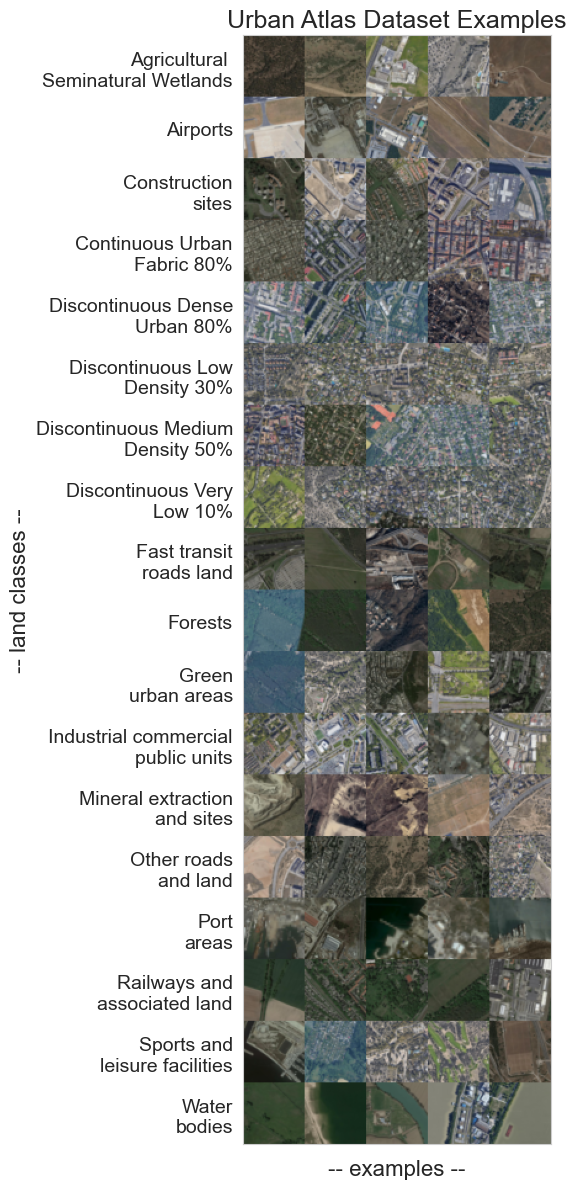

In [6]:
# plot examples of each class
n_samples = 5

sel_df = files_df.groupby("class").apply(lambda x: x.sample(n_samples))

# read image files
# files_df['image'] = files_df['filename'].apply(imread).values
images = np.array(sel_df['filename'].apply(imread).values.tolist())
labels = sel_df['class'].apply(split_str)
# labels = sel_df['class']

plot_examples(images, labels, nExamples=5, thumbSize=(
    50, 50), title="Urban Atlas Dataset Examples", save=False, plot=True)

# Resample images

In [7]:
def resample_img(path, save=False):
    # read original 512 image
    image_512 = Image.open(path)

    # resize original 512 image to 128
    image_512_resized_128 = image_512.resize((128, 128))
    if save:
        image_512_resized_128.save('test_512_resized_128.jpg')

    # get 256 image by cropping original 512
    left, top, right, bottom = 256/2, 256/2, 512 - 256/2, 512 - 256/2
    image_512_cropped_256 = image_512.crop((left, top, right, bottom))
    # image_512_cropped_256.save('test_512_cropped_256.jpg')

    # resize 256 cropped image to 128
    image_256_resized_128 = image_512_cropped_256.resize((128, 128))
    if save:
        image_256_resized_128.save('test_256_resized_128.jpg')

    # get 128 image by cropping original 512
    left, top, right, bottom = 256/2 + 128/2, 256/2 + \
        128/2, 512 - (256/2 + 128/2), 512 - (256/2 + 128/2)
    image_512_cropped_128 = image_512.crop((left, top, right, bottom))
    if save:
        image_512_cropped_128.save('test_512_cropped_128.jpg')

    return np.stack([image_512_resized_128, image_256_resized_128, image_512_cropped_128])

In [9]:
images = np.array(files_df['filename'].apply(resample_img).values.tolist())

In [10]:
images.shape

(28195, 3, 128, 128, 3)

In [16]:
classes = np.array(files_df['class'].values.tolist())

In [17]:
classes.shape

(28195,)

In [13]:
cities = np.array(files_df['city'].values.tolist())

In [14]:
cities.shape

(28195,)

Save resampled data

In [18]:
# save numpy array as npz file
from numpy import savez_compressed

# save to npz file
savez_compressed('images.npz', images)
savez_compressed('classes.npz', classes)
savez_compressed('cities.npz', cities)

Load resampled data

In [19]:
# load numpy array from npz file
from numpy import load
dict_image_data = load('images.npz')
image_data = dict_image_data['arr_0']
dict_class_data = load('classes.npz')
class_data = dict_class_data['arr_0']
dict_city_data = load('cities.npz')
city_data = dict_city_data['arr_0']

In [21]:
# all 512 images resized to 128
data_512 = image_data[:,0]
# all 512 images cropped to 256 images and resized to 128
data_256 = image_data[:,1]
# all 512 images cropped to 128 images
data_128 = image_data[:,2]

In [24]:
class_data.shape

(28195,)

In [25]:
city_data.shape

(28195,)